In [1]:
import sys
sys.path.append('../python')

from plotMethods import *
from constants import *
from distanceLossMethods import *
import plotParameters

%matplotlib inline

# General Settings

In [2]:
dataDir = '/Users/noah-everett/Documents_non-iCloud/dsps/mldata/trainData_6'
figuresDir = '../figures/UNetPreds/'

# Single File Analysis

In [3]:
fileNumber = 217 #56 #45 #30
reshapeSize = 40

In [4]:
import h5py
import numpy as np

file = f'{dataDir}/{fileNumber}.h5'
f = h5py.File(file, 'r')
x = f['x'][:]
y = f['y'][:]
f.close()

x = x[:,:,:,:]
y = y[:,:,:]

x = np.sum(x, axis=0) # sum over the 6 channels

print('x.shape:', x.shape)
print('y.shape:', y.shape)

assert x.shape == y.shape

x.shape: (80, 80, 80)
y.shape: (80, 80, 80)


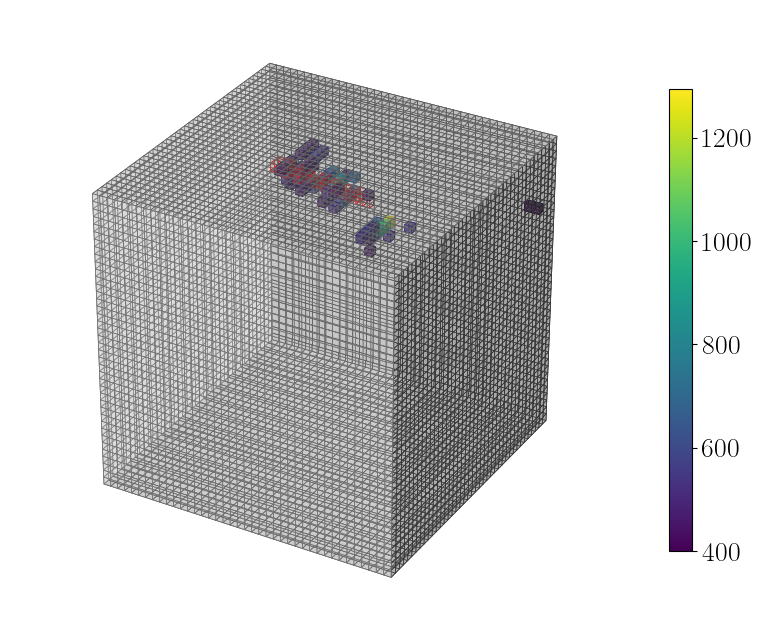

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

pred = x
true = y

step = (pred.shape[0]//reshapeSize, pred.shape[1]//reshapeSize, pred.shape[2]//reshapeSize)
assert (pred.shape[0] % reshapeSize == 0) and (pred.shape[1] % reshapeSize == 0) and (pred.shape[2] % reshapeSize == 0)
pred = pred.reshape(reshapeSize, step[0], reshapeSize, step[1], reshapeSize, step[2]).mean(axis=(1,3,5))
true = true.reshape(reshapeSize, step[0], reshapeSize, step[1], reshapeSize, step[2]).mean(axis=(1,3,5))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

gridSize = pred.shape
xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

minVal = 400
maxVal = np.max(pred)
alpha_filled = 0.5
globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)
pred = np.where(pred < minVal, 0, pred)
colors = cm.viridis(globalColorNorm(pred))

ax = plot_grid(
    ax,
    xEdges,
    yEdges,
    zEdges,
    recoGrid=pred,
    recoGridFaceColors=colors,
    recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
    recoGridAlpha=alpha_filled,
    trueGrid=true,
    trueGridEdgeColors='red',
    trueGridAlpha=0,
    nullGridAlpha=0.3,
    linewidth=0.5,
    cbar=True,
    colorNorm=globalColorNorm,
    cmap=cm.viridis,
)

ax.set_axis_off()
ax.set_aspect('equal')

# plt.savefig(f'{figuresDir}/{fileNumber}_[{predsDir}].pdf', bbox_inches='tight')
plt.show()

del pred, true

# Multi-File Analysis

In [6]:
import numpy as np

fileNumbers = np.arange(0, 1138)
# fileNumbers = np.arange(200, 220)
# fileNumbers = np.arange(0, 20)
reshapeSize = 20

In [7]:
import h5py
import numpy as np
from tqdm import tqdm

fileNames = [f'{dataDir}/{i}.h5' for i in fileNumbers]

X, Y = [], []
for i in tqdm(fileNames):
    with h5py.File(i, 'r') as f:
        x = np.sum(f['x'][:,:,:,:], axis=0)
        y = f['y'][:,:,:]
        X.append(x)
        Y.append(y)
assert len(X) == len(Y)
assert all(i.shape == j.shape for i, j in zip(X, Y))

100%|██████████| 1138/1138 [00:11<00:00, 96.17it/s]


# Voxel Distribution

Plotting histograms: 100%|██████████| 1138/1138 [00:08<00:00, 140.11it/s]


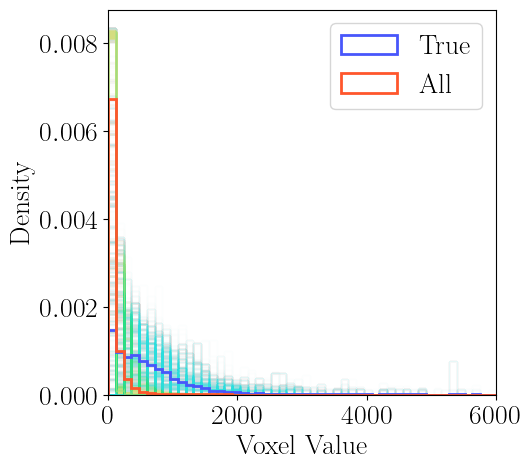

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from plotParameters import rainbow_cmap

fig, ax = plt.subplots(figsize=(5, 5))

nBins = 50
color_true_total = rainbow_cmap(0.2)
color_true_ind = rainbow_cmap(0.4)
color_all_total = rainbow_cmap(0.9)
color_all_ind = rainbow_cmap(0.7)

valsTotal = []
for x, y in tqdm(zip(X, Y), total=len(X), desc="Processing files"):
    inds = np.where(y > 0)
    vals = x[inds]
    valsTotal.append(vals)

valsTotalFlat = np.concatenate(valsTotal)
minVal = 0
maxVal = 6000 #np.max(valsTotalFlat)

for true, x in tqdm(zip(valsTotal, X), desc="Plotting histograms", total=len(X)):
    ax.hist(true, bins=nBins, alpha=0.01, density=True, range=(minVal, maxVal), 
            color=color_true_ind, histtype='step', lw=1)
    ax.hist(x.flatten(), bins=nBins, alpha=0.01, density=True, range=(minVal, maxVal), 
            color=color_all_ind, histtype='step', lw=1)
ax.hist(valsTotalFlat, bins=nBins, alpha=1, density=True, range=(minVal, maxVal), 
        color=color_true_total, histtype='step', lw=2, label='True')
ax.hist(np.array(X).flatten(), bins=nBins, alpha=1, density=True, range=(minVal, maxVal), 
        color=color_all_total, histtype='step', lw=2, label='All')

ax.set_xlabel('Voxel Value')
ax.set_ylabel('Density')
ax.set_xlim([minVal, maxVal])
ax.legend(loc='upper right')

plt.show()

del valsTotal, valsTotalFlat

# Accuracy of Max Voxel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

correct = np.zeros(len(X))
for i in tqdm(range(len(X))):
    maxInd = np.unravel_index(np.argmax(X[i], axis=None), X[i].shape)
    if Y[i][maxInd] == 1:
        correct[i] = 1
print(f'Accuracy of max voxel: {np.sum(correct)/len(correct)*100:.4f}%')




VOXEL_SIZE = (1.0, 1.0, 1.0)  # (dz, dy, dx)
_Z, _Y, _X = X[0].shape
z = np.arange(_Z, dtype=np.float32) * VOXEL_SIZE[0]
y = np.arange(_Y, dtype=np.float32) * VOXEL_SIZE[1]
x = np.arange(_X, dtype=np.float32) * VOXEL_SIZE[2]
grid_pos = np.stack(np.meshgrid(z, y, x, indexing='ij'), axis=-1).reshape(-1, 3).astype(np.float32)

distances = np.zeros(len(X))
for i, (x, y) in tqdm(enumerate(zip(X, Y)), total=len(X), desc="Calculating distances"):
    reco = np.where(x == np.max(x), x, 0)
    dist = meanDistanceFromRecoToTrue(reco, y, grid_pos=grid_pos, eps=0)
    distances[i] = dist

print(f'Mean distances from reconstructed to true: {np.mean(distances):.4f}')
print(f'Percent of max voxels which were true: {np.sum(distances == 0)/len(distances)*100:.4f}%')

for c, d in zip(correct, distances):
    if c == 1:
        print(f'Distance: {d}')

100%|██████████| 1138/1138 [00:00<00:00, 1226.24it/s]


Accuracy of max voxel: 1.7575%


Calculating distances: 100%|██████████| 1138/1138 [00:02<00:00, 455.86it/s]

Mean distances from reconstructed to true: 25.0829
Percent of max voxels which were true: 0.0000%
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 22.291454315185547
Distance: 28.634593963623047
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 22.291454315185547
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
Distance: 26.994483947753906
